In [3]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("data/data_visualization.csv", low_memory=False)

In [9]:
def optimize_dataframe(df):
    for col in df.select_dtypes(include=["float64"]).columns:
        df[col] = df[col].astype(np.float32)
    for col in df.select_dtypes(include=["int64"]).columns:
        df[col] = df[col].astype(np.int32)
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype("category")
    return df
df = optimize_dataframe(df)

In [11]:
# 마약 범죄 정의
narcotics_types = {"NARCOTICS", "OTHER NARCOTIC VIOLATION"}

# 타겟 변수 생성
df["is_narcotics"] = np.where(df["Primary Type"].isin(narcotics_types), 1, 0).astype(np.uint8)

In [15]:
# Unknown을 결측치로 변환
df["District"] = df["District"].replace('unknown', np.nan)
df["Ward"] = df["Ward"].replace('unknown', np.nan)

# int는 결측치를 가질 수 없어 float로 전환
df["District"] = df["District"].astype(np.float32)
df["Ward"] = df["Ward"].astype(np.float32)

In [17]:
# Community Area Code 이상치 제거
df = df[df['Community Area Code'] >= 1].reset_index(drop=True)

In [19]:
# category 타입을 float으로 변환
df['Y Coordinate'] = pd.to_numeric(df['Y Coordinate'], errors='coerce')

# 이상치 제거
df = df[df['Y Coordinate'] >= 10000]

In [21]:
# 분석과 예측에 불필요한 컬럼 제거
drop_cols = ["Case Number", "ID", "Latitude","Block", "Longitude", "Location", "Primary Type", "IUCR", "FBI Code", "Description"]
df = df.drop(columns=drop_cols)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

In [25]:
X = df.drop(columns="is_narcotics").copy()
y = df["is_narcotics"]

In [27]:
# category 타입 인코딩
for col in X.select_dtypes(include='category').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [33]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 모델 정의
model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    scale_pos_weight=8.15,
    n_estimators=100,
    random_state=42
)

# 학습
model.fit(X_train, y_train)

# 예측 확률
y_probs = model.predict_proba(X_test)[:, 1]

# threshold
threshold = 0.5
y_pred = (y_probs >= threshold).astype(int)

# 평가
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 539453, number of negative: 4394571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 4934024, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109333 -> initscore=-2.097570
[LightGBM] [Info] Start training from score -2.097570
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1098643
           1       0.48      0.98      0.65    134863

    accuracy                           0.88   1233506
   macro avg       0.74      0.93      0.79   1233506
weighted avg       0.94      0.88      0.90   1233506



Class|Precision|Recall|F1-score|
|------|---|---|---|
|0 (비마약 범죄)|1.00|0.87|0.93|
|1 (마약 범죄)|0.48|0.98|0.65|
|Marco Average|0.74|0.93|0.79|
|Weighted Average|0.94|0.88|0.90|

Model|Accuracy(%)|Macro F1(%)|
|------|---|---|
|LightGBM|93|81|

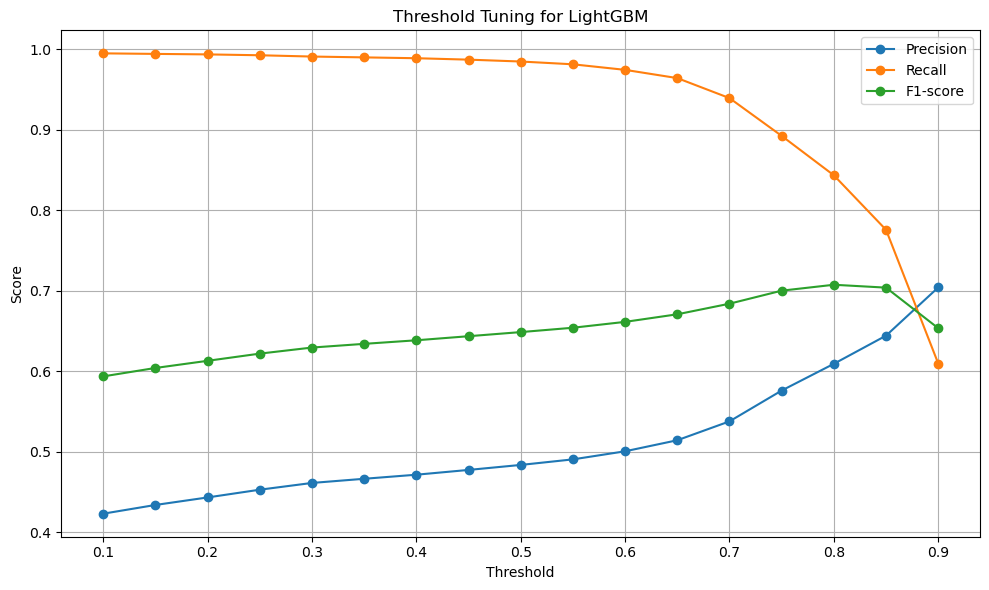

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# 예측 확률 (마약 클래스: 1에 대한 확률)
y_scores = model.predict_proba(X_test)[:, 1]

# 임계값 후보
thresholds = np.arange(0.1, 0.91, 0.05)

# 결과 저장
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1-score', marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning for LightGBM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# 예측 확률 얻기
y_scores = model.predict_proba(X_test)[:, 1]

# 최적의 threshold로 커스텀 예측
optimal_threshold = 0.8
y_pred = (y_scores >= optimal_threshold).astype(int)

# 평가
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96   1098643
           1       0.61      0.84      0.71    134863

    accuracy                           0.92   1233506
   macro avg       0.79      0.89      0.83   1233506
weighted avg       0.94      0.92      0.93   1233506



Class|Precision|Recall|F1-score|
|------|---|---|---|
|0 (비마약 범죄)|0.98|0.93|0.96|
|1 (마약 범죄)|0.61|0.84|0.71|
|Marco Average|0.79|0.89|0.83|
|Weighted Average|0.94|0.92|0.93|

Model|Accuracy(%)|Macro F1(%)|
|------|---|---|
|LightGBM|92|83|

Model|Accuracy(%)|Macro F1(%)|
|------|---|---|
|RandomForest|93|83|
|XGBoost|92|83|
|LightGBM|92|83|